Carregando dados do arquivo: ADD_Recomenda_Compra.xlsx
Total de produtos carregados: 704
Colunas disponíveis: cd_produto, desc_produto, 2024_01, 2024_02, 2024_03, 2024_04, 2024_05, 2024_06, 2024_07, 2024_08, 2024_09, 2024_10, 2024_11, 2024_12, 2025_01, 2025_02, 2025_03, fornecedor, estoque_11-03-25, Media 3M, Cobertura, Sug 3M, Sug 1M, Data1, Quantidade1, custo1, Fornecedor1, Data2, Quantidade2, custo2, Fornecedor2, Data3, Quantidade3, custo3, Fornecedor3
Valores em custo1 ANTES da conversão:
0     R$ 2,90 
1     R$ 3,58 
2     R$ 1,55 
3     R$ 0,35 
4     R$ 1,34 
5     R$ 0,85 
6     R$ 5,62 
7     R$ 0,85 
8     R$ 0,83 
9     R$ 1,97 
Name: custo1, dtype: object
Tipo de dados da coluna custo1: object
Exemplos de valores em custo1: [' R$ 2,90 ', ' R$ 3,58 ', ' R$ 1,55 ', ' R$ 0,35 ', ' R$ 1,34 ']
Valores em custo1 DEPOIS da conversão:
0    2.90
1    3.58
2    1.55
3    0.35
4    1.34
5    0.85
6    5.62
7    0.85
8    0.83
9    1.97
Name: custo1, dtype: float64
Percentual de cobert

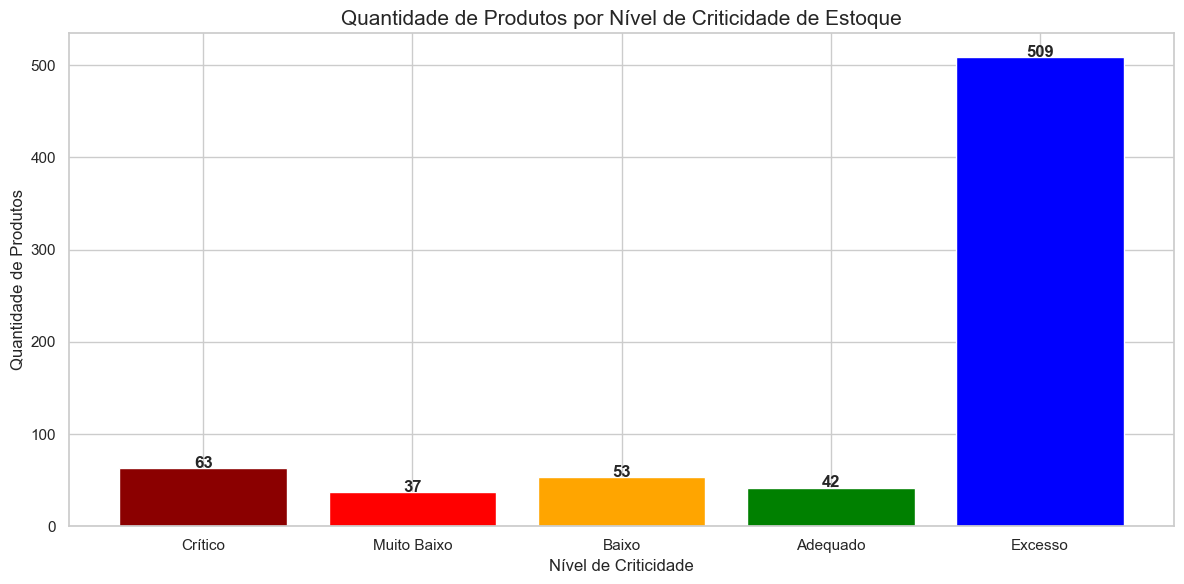

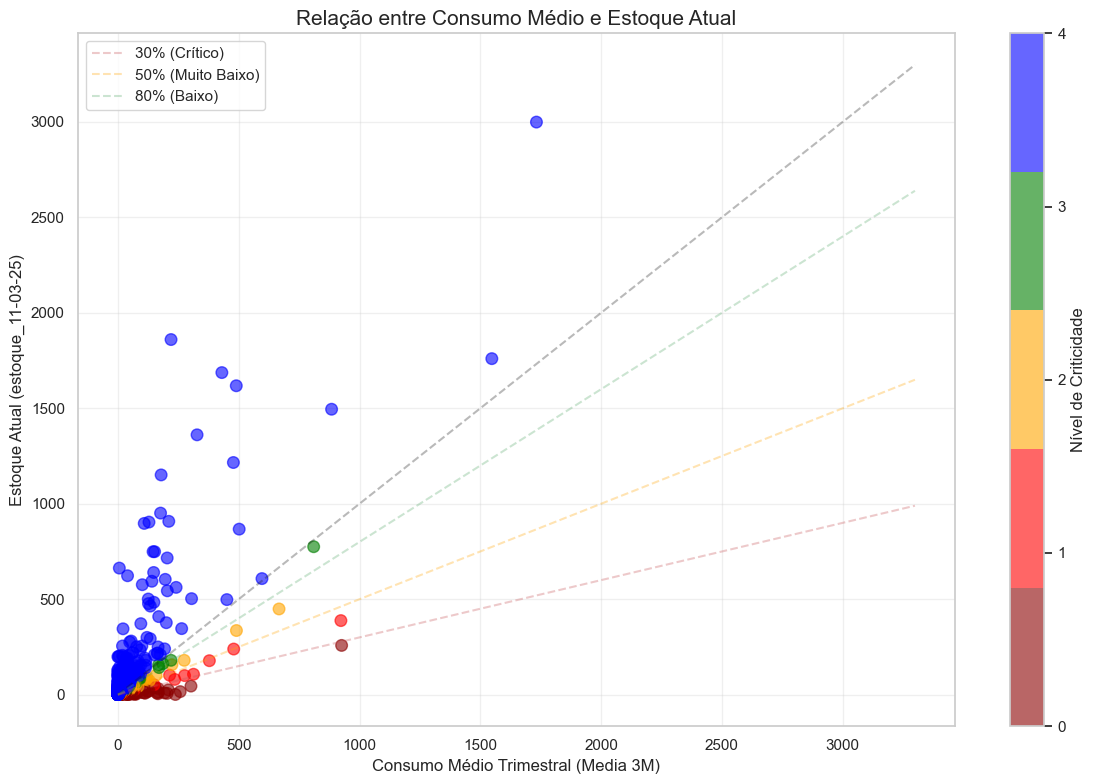

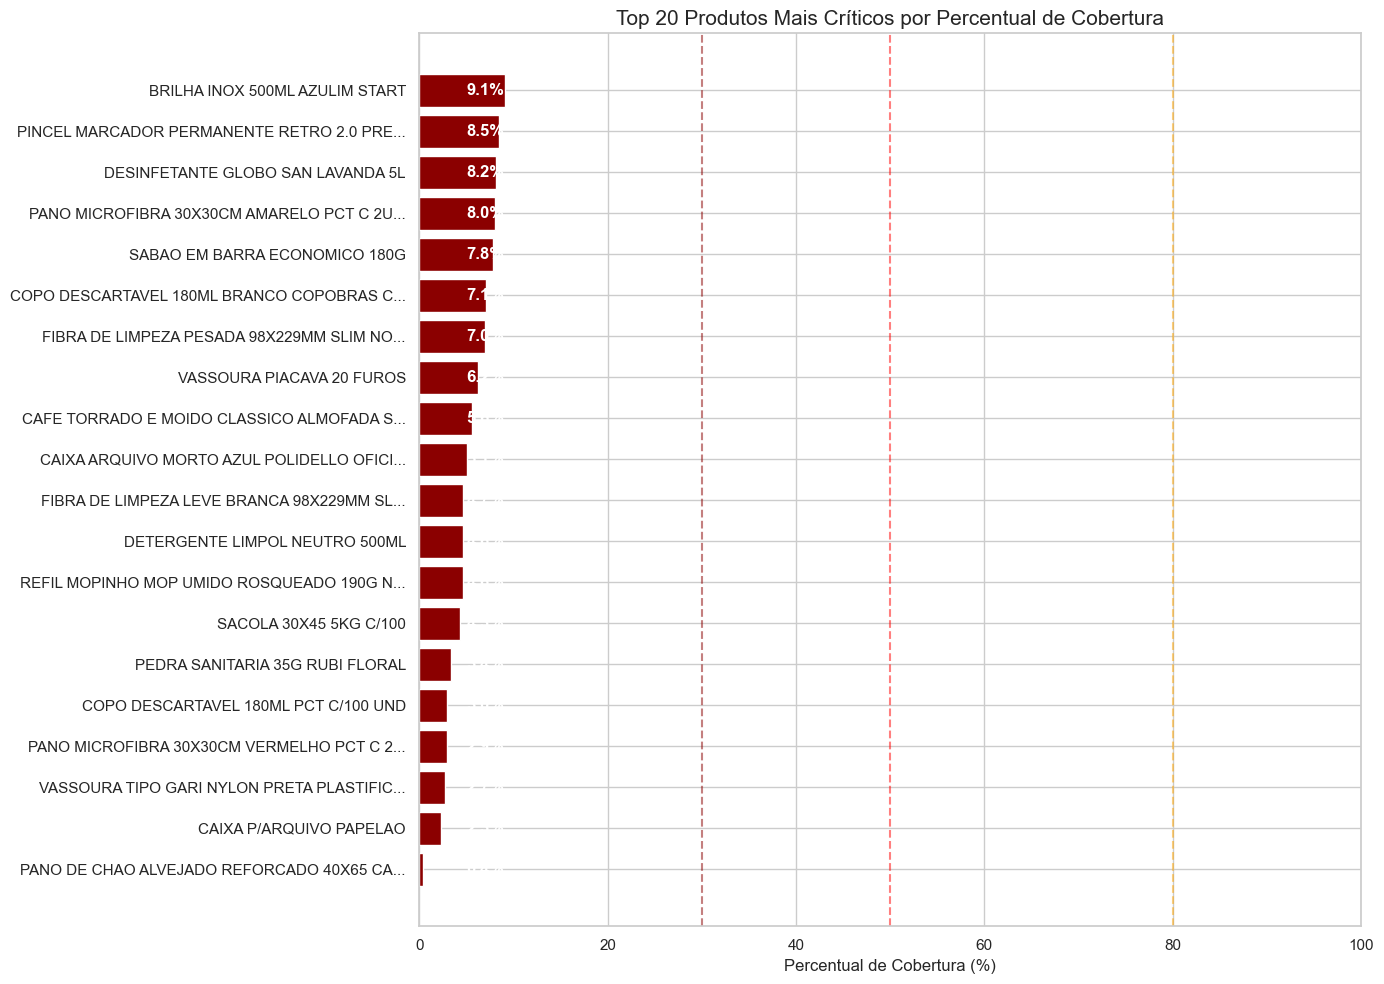


Resumo de Criticidade de Estoque:
  Nível de Criticidade  Quantidade de Produtos  Percentual do Total
0              Crítico                      63                  8.9
1          Muito Baixo                      37                  5.3
2                Baixo                      53                  7.5
3             Adequado                      42                  6.0
4              Excesso                     509                 72.3

Resumo de Valores de Compra:
Valor total estimado para compra: R$ -82,287.62
Valor para produtos críticos: R$ 53,185.02 (-64.6%)
Valor para produtos muito baixos: R$ 13,058.71 (-15.9%)


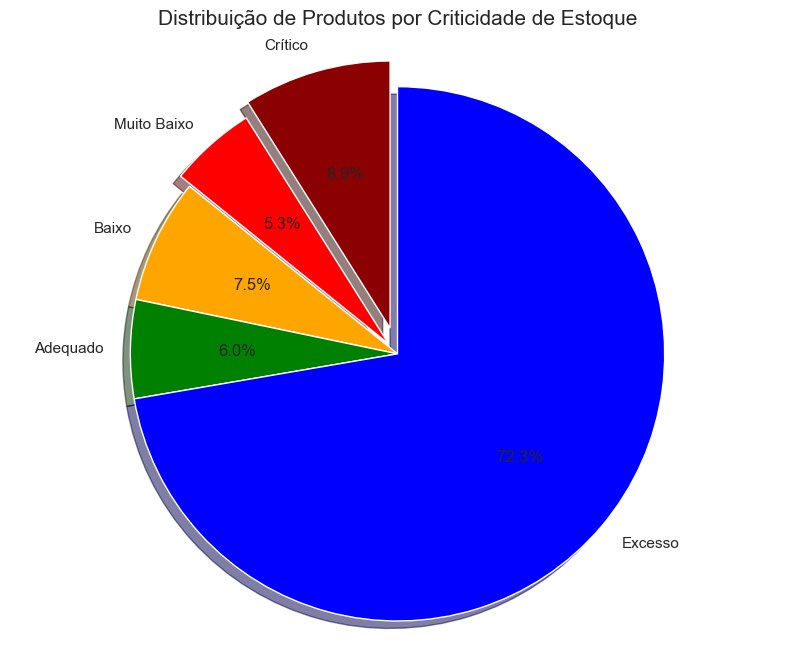

Preparando Excel para dashboard: relatorio_produtos.xlsx
Arquivo Excel 'relatorio_produtos.xlsx' criado com sucesso!

Estrutura do arquivo:
- Dados_Completos: Todos os dados com métricas calculadas
- Resumo_Criticidade: Contagens por nível de criticidade
- Dados_Dispersao: Dados para o gráfico de dispersão
- Top20_Criticos: Os 20 produtos mais críticos
- Resumo_Valores: Valores de compra estimados por criticidade

Análise concluída com sucesso!


/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_36647/1092203724.py:379: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo_valores = df.groupby('criticidade')['valor_estimado_1m'].sum().reset_index()


In [9]:
"""
Script para analisar dados de estoque e gerar gráficos de cobertura.

Este script lê um arquivo Excel 'ADD_Recomenda_Compra.xlsx', calcula métricas de cobertura
e gera gráficos para auxiliar na tomada de decisão de compra.

Colunas consideradas:
cd_produto, desc_produto, 2025_03, fornecedor, estoque_11-03-25, Media 3M, 
Cobertura, Sug 3M, Sug 1M, Data1, Quantidade1, custo1, Fornecedor1, 
Data2, Quantidade2, custo2, Fornecedor2, Data3, Quantidade3, custo3, Fornecedor3
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os

# Configurações visuais
plt.style.use('ggplot')
sns.set(style="whitegrid")

def analisar_estoque(arquivo_excel="ADD_Recomenda_Compra.xlsx"):
    """
    Analisa os dados de estoque e gera gráficos.
    
    Args:
        arquivo_excel (str): Caminho para o arquivo Excel com os dados de estoque
    """
    # Verificar se o arquivo existe
    if not os.path.exists(arquivo_excel):
        print(f"ERRO: O arquivo {arquivo_excel} não foi encontrado.")
        print(f"Diretório atual: {os.getcwd()}")
        print(f"Arquivos disponíveis: {os.listdir()}")
        return None
    
    # Carregar os dados
    print(f"Carregando dados do arquivo: {arquivo_excel}")
    df = pd.read_excel(arquivo_excel)
    
    # Verificar e limpar os dados
    print(f"Total de produtos carregados: {len(df)}")
    print(f"Colunas disponíveis: {', '.join(df.columns.tolist())}")
    
    # Mapeamento das colunas específicas para os nomes padronizados que usaremos na análise
    mapeamento_colunas = {
        'cd_produto': 'cd_produto',
        'desc_produto': 'desc_produto',
        'estoque_11-03-25': 'estoque_atual',  # Estoque atual
        'Media 3M': 'media_3m',               # Média de consumo trimestral
        'Cobertura': 'cobertura',             # Cobertura em meses
        'Sug 3M': 'sugestao_3m',              # Sugestão para 3 meses
        'Sug 1M': 'sugestao_1m',              # Sugestão para 1 mês
        'custo1': 'custo1'                    # Custo unitário da última compra
    }
    
    # Verificar quais colunas esperadas estão presentes
    colunas_faltantes = [col for col in mapeamento_colunas.keys() if col not in df.columns]
    
    if colunas_faltantes:
        print(f"AVISO: As seguintes colunas esperadas não foram encontradas: {colunas_faltantes}")
        
        # Verificar se existem colunas similares que podemos usar
        for col_faltante in colunas_faltantes.copy():
            # Verificar se alguma coluna contém o nome da coluna faltante
            colunas_similares = [col for col in df.columns if col_faltante.lower() in col.lower()]
            if colunas_similares:
                print(f"  Usando '{colunas_similares[0]}' como substituto para '{col_faltante}'")
                df[col_faltante] = df[colunas_similares[0]]
                colunas_faltantes.remove(col_faltante)
    
    # Verificar se ainda existem colunas faltantes críticas
    colunas_criticas = ['estoque_11-03-25', 'Media 3M']
    colunas_criticas_faltantes = [col for col in colunas_criticas if col not in df.columns]
    
    if colunas_criticas_faltantes:
        print("ERRO: Não foi possível encontrar colunas essenciais para a análise.")
        return None

    # if 'custo1' in df.columns:
    #     print("Valores em custo1 ANTES da conversão:")
    #     print(df['custo1'].head(10))
    
    # Converter colunas numéricas
    for col in ['estoque_11-03-25', 'Media 3M', 'Cobertura', 'Sug 3M', 'Sug 1M']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    # Tratamento especial para custo1 (assumindo formato de moeda)
    if 'custo1' in df.columns:
        # Primeiro, verificar o tipo de dados
        print(f"Tipo de dados da coluna custo1: {df['custo1'].dtype}")
        print(f"Exemplos de valores em custo1: {df['custo1'].head().tolist()}")
        
        # Se for string com formatação de moeda
        if df['custo1'].dtype == object:
            # Remover caracteres não numéricos (R$, espaços, etc) e substituir vírgula por ponto
            df['custo1'] = df['custo1'].astype(str).str.replace('R$', '', regex=False) \
                                               .str.replace(' ', '', regex=False) \
                                               .str.replace('.', '', regex=False) \
                                               .str.replace(',', '.', regex=False)
    # df['custo1'] = pd.to_numeric(df['custo1'], errors='coerce')
    # if 'Media 3M' in df.columns:
    #     print("Valores em custo1 DEPOIS da conversão:")
    #     print(df['custo1'].head(10))

    
    # Remover linhas com valores NaN nas colunas essenciais
    df_limpo = df.dropna(subset=[col for col in colunas_criticas if col in df.columns])
    if len(df_limpo) < len(df):
        print(f"AVISO: {len(df) - len(df_limpo)} linhas removidas devido a valores ausentes.")
    
    df = df_limpo
    
    # Calcular percentual de cobertura se 'Cobertura' não estiver disponível
    if 'Cobertura' not in df.columns:
        if 'estoque_11-03-25' in df.columns and 'Media 3M' in df.columns:
            df['percentual_cobertura'] = (df['estoque_11-03-25'] / df['Media 3M'] * 100).round(1)
            print("Percentual de cobertura calculado a partir do estoque atual e média 3M")
    else:
        # Usar a coluna 'Cobertura' para calcular o percentual (assumindo que Cobertura está em meses)
        df['percentual_cobertura'] = (df['Cobertura'] * 100).round(1)
        print("Percentual de cobertura calculado a partir da coluna Cobertura")
    
    # Definir categorias de criticidade
    df['criticidade'] = pd.cut(
        df['percentual_cobertura'],
        bins=[-float('inf'), 30, 50, 80, 100, float('inf')],
        labels=['Crítico', 'Muito Baixo', 'Baixo', 'Adequado', 'Excesso']
    )
    
    # Contar produtos por categoria de criticidade
    contagem_criticidade = df['criticidade'].value_counts().sort_index()
    
    # Gerar gráfico de barras para criticidade
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        contagem_criticidade.index, 
        contagem_criticidade.values,
        color=['darkred', 'red', 'orange', 'green', 'blue']
    )
    
    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.1,
            f'{int(height)}',
            ha='center', 
            fontweight='bold'
        )
    
    plt.title('Quantidade de Produtos por Nível de Criticidade de Estoque', fontsize=15)
    plt.xlabel('Nível de Criticidade', fontsize=12)
    plt.ylabel('Quantidade de Produtos', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    # Salvar o gráfico
    # plt.savefig('grafico_criticidade_estoque.png', dpi=300, bbox_inches='tight')
    # print("Gráfico salvo como 'grafico_criticidade_estoque.png'")
    
    # Mostrar o gráfico (opcional, dependendo do ambiente)
    plt.show()
    
    # Gerar gráfico de dispersão para relação entre estoque e consumo médio
    plt.figure(figsize=(12, 8))
    
    # Criar um colormap personalizado
    colors = ['darkred', 'red', 'orange', 'green', 'blue']
    n_bins = 5
    cmap_name = 'criticidade_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Usar a variável criticidade para colorir os pontos
    criticidade_num = pd.Categorical(df['criticidade']).codes
    
    # Plotar os pontos
    scatter = plt.scatter(
        df['Media 3M'], 
        df['estoque_11-03-25'],
        c=criticidade_num, 
        cmap=cm,
        alpha=0.6, 
        s=70
    )
    
    # Adicionar linha de referência para 100% de cobertura
    max_val = max(df['Media 3M'].max(), df['estoque_11-03-25'].max()) * 1.1
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    
    # Adicionar linhas de referência para outros níveis
    plt.plot([0, max_val], [0, max_val*0.3], 'r--', alpha=0.3, label='30% (Crítico)')
    plt.plot([0, max_val], [0, max_val*0.5], 'orange', linestyle='--', alpha=0.3, label='50% (Muito Baixo)')
    plt.plot([0, max_val], [0, max_val*0.8], 'g--', alpha=0.3, label='80% (Baixo)')
    
    # Configurar legendas e títulos
    plt.colorbar(scatter, label='Nível de Criticidade', ticks=range(5))
    plt.title('Relação entre Consumo Médio e Estoque Atual', fontsize=15)
    plt.xlabel('Consumo Médio Trimestral (Media 3M)', fontsize=12)
    plt.ylabel('Estoque Atual (estoque_11-03-25)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Salvar o gráfico
    # plt.savefig('grafico_dispersao_estoque_consumo.png', dpi=300, bbox_inches='tight')
    # print("Gráfico salvo como 'grafico_dispersao_estoque_consumo.png'")
    
    # Mostrar o gráfico
    plt.show()
    
    # Gerar ranking dos 20 produtos mais críticos
    df_criticos = df.sort_values('percentual_cobertura').head(20)
    
    # Preparar dados para gráfico horizontal de barras
    plt.figure(figsize=(14, 10))
    
    # Criar descrições mais curtas para os produtos
    df_criticos['desc_curta'] = df_criticos['desc_produto'].apply(
        lambda x: (str(x)[:40] + '...') if len(str(x)) > 40 else x
    )
    
    # Criar barras com cores baseadas na criticidade
    cores = []
    for perc in df_criticos['percentual_cobertura']:
        if perc <= 30:
            cores.append('darkred')
        elif perc <= 50:
            cores.append('red')
        elif perc <= 80:
            cores.append('orange')
        else:
            cores.append('green')
    
    # Plotar barras horizontais
    bars = plt.barh(
        df_criticos['desc_curta'], 
        df_criticos['percentual_cobertura'],
        color=cores
    )
    
    # Adicionar valores nas barras
    for bar in bars:
        width = bar.get_width()
        plt.text(
            max(5, width - 10),
            bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}%',
            va='center',
            color='white' if width < 50 else 'black',
            fontweight='bold'
        )
    
    # Adicionar linhas de referência
    plt.axvline(x=30, color='darkred', linestyle='--', alpha=0.5)
    plt.axvline(x=50, color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=80, color='orange', linestyle='--', alpha=0.5)
    
    # Configurar eixos e títulos
    plt.title('Top 20 Produtos Mais Críticos por Percentual de Cobertura', fontsize=15)
    plt.xlabel('Percentual de Cobertura (%)', fontsize=12)
    plt.xlim(0, 100)
    plt.tight_layout()
    
    # Salvar o gráfico
    # plt.savefig('grafico_top20_criticos.png', dpi=300, bbox_inches='tight')
    # print("Gráfico salvo como 'grafico_top20_criticos.png'")
    
    # Mostrar o gráfico
    plt.show()
    
    # Gerar tabela com informações de criticidade
    tabela_criticidade = pd.DataFrame({
        'Nível de Criticidade': contagem_criticidade.index,
        'Quantidade de Produtos': contagem_criticidade.values,
        'Percentual do Total': (contagem_criticidade.values / len(df) * 100).round(1)
    })
    
    print("\nResumo de Criticidade de Estoque:")
    print(tabela_criticidade)
    
    # Gerar estatísticas de sugestão de compra
    if 'Sug 1M' in df.columns and 'custo1' in df.columns:
        df['valor_estimado_1m'] = df['Sug 1M'] * df['custo1']
        
        valor_total = df['valor_estimado_1m'].sum()
        valor_critico = df[df['criticidade'] == 'Crítico']['valor_estimado_1m'].sum()
        valor_muito_baixo = df[df['criticidade'] == 'Muito Baixo']['valor_estimado_1m'].sum()
        
        print("\nResumo de Valores de Compra:")
        print(f"Valor total estimado para compra: R$ {valor_total:,.2f}")
        print(f"Valor para produtos críticos: R$ {valor_critico:,.2f} ({valor_critico/valor_total*100:.1f}%)")
        print(f"Valor para produtos muito baixos: R$ {valor_muito_baixo:,.2f} ({valor_muito_baixo/valor_total*100:.1f}%)")
    
    # Criar gráfico de pizza para distribuição de criticidade
    plt.figure(figsize=(10, 8))
    plt.pie(
        contagem_criticidade.values, 
        labels=contagem_criticidade.index,
        autopct='%1.1f%%',
        colors=['darkred', 'red', 'orange', 'green', 'blue'],
        explode=[0.1, 0.05, 0, 0, 0],  # Destacar categorias críticas
        shadow=True,
        startangle=90
    )
    plt.axis('equal')
    plt.title('Distribuição de Produtos por Criticidade de Estoque', fontsize=15)
    
    # Salvar o gráfico
    # plt.savefig('grafico_pizza_criticidade.png', dpi=300, bbox_inches='tight')
    # print("Gráfico salvo como 'grafico_pizza_criticidade.png'")
    
    # Mostrar o gráfico
    plt.show()
    
    # Criar relatório dos produtos críticos em formato tabular
    if len(df_criticos) > 0:
        # Selecionando colunas relevantes para o relatório
        colunas_relatorio = ['cd_produto', 'desc_produto', 'estoque_11-03-25', 'Media 3M', 
                             'percentual_cobertura', 'criticidade']
        
        if 'Sug 1M' in df.columns:
            colunas_relatorio.append('Sug 1M')
        
        if 'custo1' in df.columns:
            colunas_relatorio.append('custo1')
            
        if 'Fornecedor1' in df.columns:
            colunas_relatorio.append('Fornecedor1')
        
        # Filtrar apenas colunas disponíveis
        colunas_relatorio = [col for col in colunas_relatorio if col in df.columns]
        
        # Criar e salvar o relatório em EXCEL
        # df_criticos[colunas_relatorio].to_excel('relatorio_produtos_criticostop20.xlsx', index=False)
        # print("Relatório de produtos críticos salvo como 'relatorio_produtos_criticostop20.xlsx'")

    exportar_excel_para_dashboard(df)
    
    return df

def exportar_excel_para_dashboard(df, arquivo_saida="relatorio_produtos.xlsx"):
    """
    Exporta os dados processados para um arquivo Excel estruturado que pode ser 
    utilizado como fonte de dados para um dashboard.
    
    Args:
        df (pandas.DataFrame): DataFrame com os dados processados
        arquivo_saida (str): Nome do arquivo Excel de saída
    """
    import pandas as pd
    
    print(f"Preparando Excel para dashboard: {arquivo_saida}")
    
    # 1. Dados completos com todas as métricas calculadas
    df_completo = df.copy()
    
    # 2. Resumo de criticidade (para gráfico de barras e pizza)
    contagem_criticidade = df['criticidade'].value_counts().sort_index()
    df_criticidade = pd.DataFrame({
        'nivel_criticidade': contagem_criticidade.index,
        'quantidade': contagem_criticidade.values,
        'percentual': (contagem_criticidade.values / len(df) * 100).round(1)
    })
    
    # 3. Dados para gráfico de dispersão
    df_dispersao = df[['cd_produto', 'desc_produto', 'estoque_11-03-25', 'Media 3M', 
                      'percentual_cobertura', 'criticidade']].copy()
    
    # 4. Top 20 produtos mais críticos
    df_top20_criticos = df.sort_values('percentual_cobertura').head(20)
    
    # 5. Resumo de valores por criticidade (se disponível)
    if 'valor_estimado_1m' in df.columns:
        resumo_valores = df.groupby('criticidade')['valor_estimado_1m'].sum().reset_index()
        resumo_valores['percentual'] = (resumo_valores['valor_estimado_1m'] / resumo_valores['valor_estimado_1m'].sum() * 100).round(1)
    else:
        resumo_valores = pd.DataFrame(columns=['criticidade', 'valor_estimado_1m', 'percentual'])
    
    # Criar um arquivo Excel com várias abas
    with pd.ExcelWriter(arquivo_saida, engine='xlsxwriter') as writer:
        # Adicionar cada DataFrame como uma aba
        df_completo.to_excel(writer, sheet_name='Dados_Completos', index=False)
        df_criticidade.to_excel(writer, sheet_name='Resumo_Criticidade', index=False)
        df_dispersao.to_excel(writer, sheet_name='Dados_Dispersao', index=False)
        df_top20_criticos.to_excel(writer, sheet_name='Top20_Criticos', index=False)
        
        if not resumo_valores.empty:
            resumo_valores.to_excel(writer, sheet_name='Resumo_Valores', index=False)
    
    print(f"Arquivo Excel '{arquivo_saida}' criado com sucesso!")
    print("\nEstrutura do arquivo:")
    print("- Dados_Completos: Todos os dados com métricas calculadas")
    print("- Resumo_Criticidade: Contagens por nível de criticidade")
    print("- Dados_Dispersao: Dados para o gráfico de dispersão")
    print("- Top20_Criticos: Os 20 produtos mais críticos")
    
    if not resumo_valores.empty:
        print("- Resumo_Valores: Valores de compra estimados por criticidade")

if __name__ == "__main__":
    try:
        df_resultado = analisar_estoque()
        if df_resultado is not None:
            print("\nAnálise concluída com sucesso!")
    except Exception as e:
        print(f"Erro durante a análise: {e}")